### 1. Initial Training

In [1]:
from src.models.transfer_nlp_utils import DataProcessor, Trainer, set_seed, get_training_objects

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
%matplotlib inline

In [2]:
import random
params = {
    'num_epochs': 10,
    'weight_decay': 0.1,
    'adam_epsilon': 1e-6,
    'model_name': 'roberta-base',
    'max_grad_norm': 1.0,
    'lr': 1e-5,
    'bs': 64,
    'device': 'cuda',
    'task': 'cola',
    'data_dir': '../data/external/CoLA',
    'max_seq_length': 50,          
    'metric_name': 'mcc',
    'patience': 3,
    'seed': random.randint(1, 1000),
    'n': -1,
    'total_steps': 5336, 
    'warmup_steps': 320
}

In [3]:
set_seed(params['seed'])
dp = DataProcessor(params)
trainer = Trainer(params, dp, *get_training_objects(params))
trainer.fit()

Training roberta-base with lr = 1e-05,bs = 64, n = -1
------------------------------------------------------------------------------------------------------


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch   1/10 | Loss:  0.65 (T)  0.60 (V) | MCC: 0.008 (T) 0.000 (V) | LR: 4.2e-06 | Time: 32.70s 
------------------------------------------------------------------------------------------------------
Epoch   2/10 | Loss:  0.27 (T)  0.27 (V) | MCC: 0.179 (T) 0.425 (V) | LR: 8.4e-06 | Time: 32.22s 
------------------------------------------------------------------------------------------------------
Epoch   3/10 | Loss:  0.15 (T)  0.16 (V) | MCC: 0.517 (T) 0.485 (V) | LR: 9.8e-06 | Time: 32.22s 
------------------------------------------------------------------------------------------------------
Epoch   4/10 | Loss:  0.09 (T)  0.13 (V) | MCC: 0.650 (T) 0.529 (V) | LR: 9.6e-06 | Time: 32.24s 
------------------------------------------------------------------------------------------------------
Epoch   5/10 | Loss:  0.06 (T)  0.10 (V) | MCC: 0.736 (T) 0.581 (V) | LR: 9.3e-06 | Time: 32.33s 
--------------------------------------------------------------------------------------------------

### 2. Running Inference with Monte Carlo Dropout

In [4]:
del trainer.scheduler, trainer.optimizer

In [5]:
class MonteCarloDropout:
    """Runs Monte Carlo dropout inference and stores results. 
    Also stores naive confidence scores associated with softmax output.
    """
    
    def __init__(self, model, dataloader, n_iter, device):
        self.model = model
        self.dataloader = dataloader
        self.n_iter = n_iter
        self.device = device
        self.nv_conf = []
        self.nv_pred = []        
        self.mc_pred = []
        self.mc_conf = []
        self.obs = []
        self.results = []
                    
    def _infer_one_batch(self, batch):
        probas = []
        with torch.no_grad():
            xb, mb, _, yb = tuple(t.to(self.device) for t in batch)
            for i in range(self.n_iter):
                outputs = self.model(input_ids=xb, attention_mask=mb, labels=yb)
                proba = torch.nn.functional.softmax(outputs[1], dim=1)
                if i == 0:
                    self.nv_conf.append(torch.max(proba, dim=1)[0].cpu().numpy())
                    self.nv_pred.append(proba[:,-1].cpu().numpy())
                probas.append(proba[:,-1].unsqueeze(-1))
            probas = torch.cat(probas, dim=1)
            assert probas[0,0] != probas[0,1], 'Make sure dropout is turned on'
            self.mc_pred.append(probas.mean(dim=1).cpu().numpy())
            self.mc_conf.append(probas.std(dim=1).cpu().numpy())
            self.obs.append(yb.cpu().numpy())
            
    def _aggregate_results(self, pred_cutoff=0.5):
        df = pd.DataFrame({
            'nv_conf': np.concatenate(self.nv_conf), 
            'nv_pred': np.concatenate(self.nv_pred),
            'mc_pred': np.concatenate(self.mc_pred), 
            'mc_conf': np.concatenate(self.mc_conf),
            'obs': np.concatenate(self.obs)
        })
        df['nv_pred_cls'] = (df['nv_pred'] > pred_cutoff).astype(int)
        df['mc_pred_cls'] = (df['mc_pred'] > pred_cutoff).astype(int)
        self.results = df
        
    def run_inference(self):
        self.model.train()
        for batch in self.dataloader:
            self._infer_one_batch(batch)
        self._aggregate_results()

In [6]:
mcdo = MonteCarloDropout(trainer.model, dp.valid_dataloader, 5, 'cuda')
mcdo.run_inference()
mcdo.results.head()

,nv_conf,nv_pred,mc_pred,mc_conf,obs,nv_pred_cls,mc_pred_cls
0,0.984419,0.984419,0.870510,0.247130,1,1,1
1,0.997587,0.997587,0.996291,0.001367,1,1,1
2,0.985419,0.985419,0.759916,0.365820,1,1,1
3,0.996002,0.996002,0.990035,0.012091,1,1,1
4,0.604447,0.395553,0.373219,0.196422,0,0,0


### 3. Caclulate Coverage vs. Accuracy

In [13]:
def sort_filter(df, pct, sort_key, ascending):
    n_obs = int(pct * df.shape[0])
    return df.sort_values(sort_key, ascending=ascending).head(n_obs)

def accuracy(y_pred, y_obs):
    return (y_pred==y_obs).mean()

def calc_accuracies(coverages, df, sort_key, ascending):
    accuracies = []
    for coverage in coverages:
        df_high_conf = sort_filter(df, coverage, sort_key+'_conf', ascending)
        accuracies.append(accuracy(df_high_conf[sort_key+'_pred_cls'], df_high_conf.obs))
    return accuracies

def visualize(x, y_li, label_li, title=None):
    fig1, ax1 = plt.subplots(figsize=(10,8))
    ax1.plot(x, y_li[0], 'go', markersize=10, alpha=.8, label=label_li[0])
    ax1.plot(x, y_li[1], 'bo', markersize=10, alpha=.8, label=label_li[1])
    ax1.set_xlabel('Coverage')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0.80, 1])
    ax1.grid(True)
    ax1.set_title(title)
    ax1.set_xticks(x)
    ax1.legend()

In [14]:
coverages = [1, 0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.3, 0.2, 0.1]
accuracies_mc = calc_accuracies(coverages, mcdo.results, 'mc', True)
accuracies_nv = calc_accuracies(coverages, mcdo.results, 'nv', False)

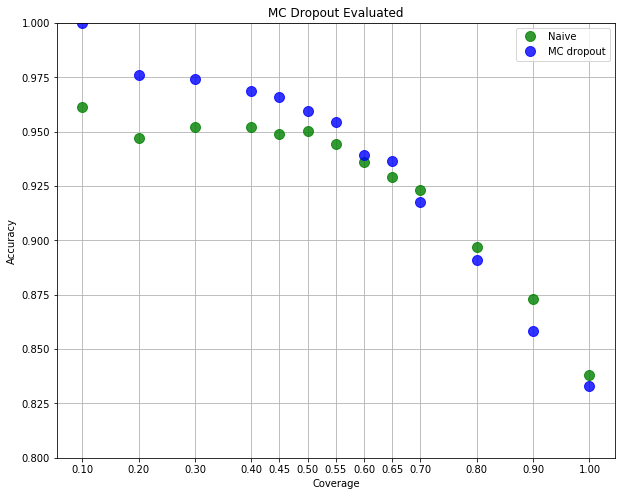

In [15]:
visualize(coverages, [accuracies_nv, accuracies_mc], ['Naive', 'MC dropout'], 'MC Dropout Evaluated')